In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sb
from sklearn.decomposition import NMF

# Loading the data
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'gray'})
data = pd.read_csv("data/forNMF_350_850_normalized_by_apogee.csv")
data.drop(columns=data.columns[0], axis=1,  inplace=True)
data = data[data['Meter'] > 1]
curve_columns = data.columns[0:150]
data['meanCurveValue'] = data[curve_columns].mean(axis=1)
data = data[data['meanCurveValue'] < 30] # TODO
print(data)


             353        356        359        363        366        369  \
79      2.881260   2.911879   3.519868   3.544630   3.416003   3.396207   
80      3.027650   2.994665   3.627177   3.672717   3.515654   3.501742   
81      3.212806   3.201684   3.912144   3.961563   3.743247   3.791581   
82      2.807189   2.872891   3.536646   3.515218   3.442610   3.447435   
83      3.028180   3.014566   3.670088   3.769465   3.575679   3.547810   
...          ...        ...        ...        ...        ...        ...   
11460  30.421288  29.386884  32.790397  31.948612  29.794621  29.271311   
11461  31.130467  30.022422  33.419581  32.488324  30.277005  29.774766   
11462  37.025514  35.751751  40.102273  39.075976  36.376634  35.798666   
11465  51.335152  49.136354  55.189733  53.547468  50.258905  49.714594   
11468  48.217757  46.090309  51.471092  50.517245  46.790751  46.416417   

             373        376        379        383  ...       843       846  \
79      3.643360   3.

/tmp/ipykernel_9787/222486440.py:14: DtypeWarning: Columns (155) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/forNMF_350_850_normalized_by_apogee.csv")


/tmp/ipykernel_9787/184622707.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  p = sb.scatterplot(tmp, y='value', x='variable',


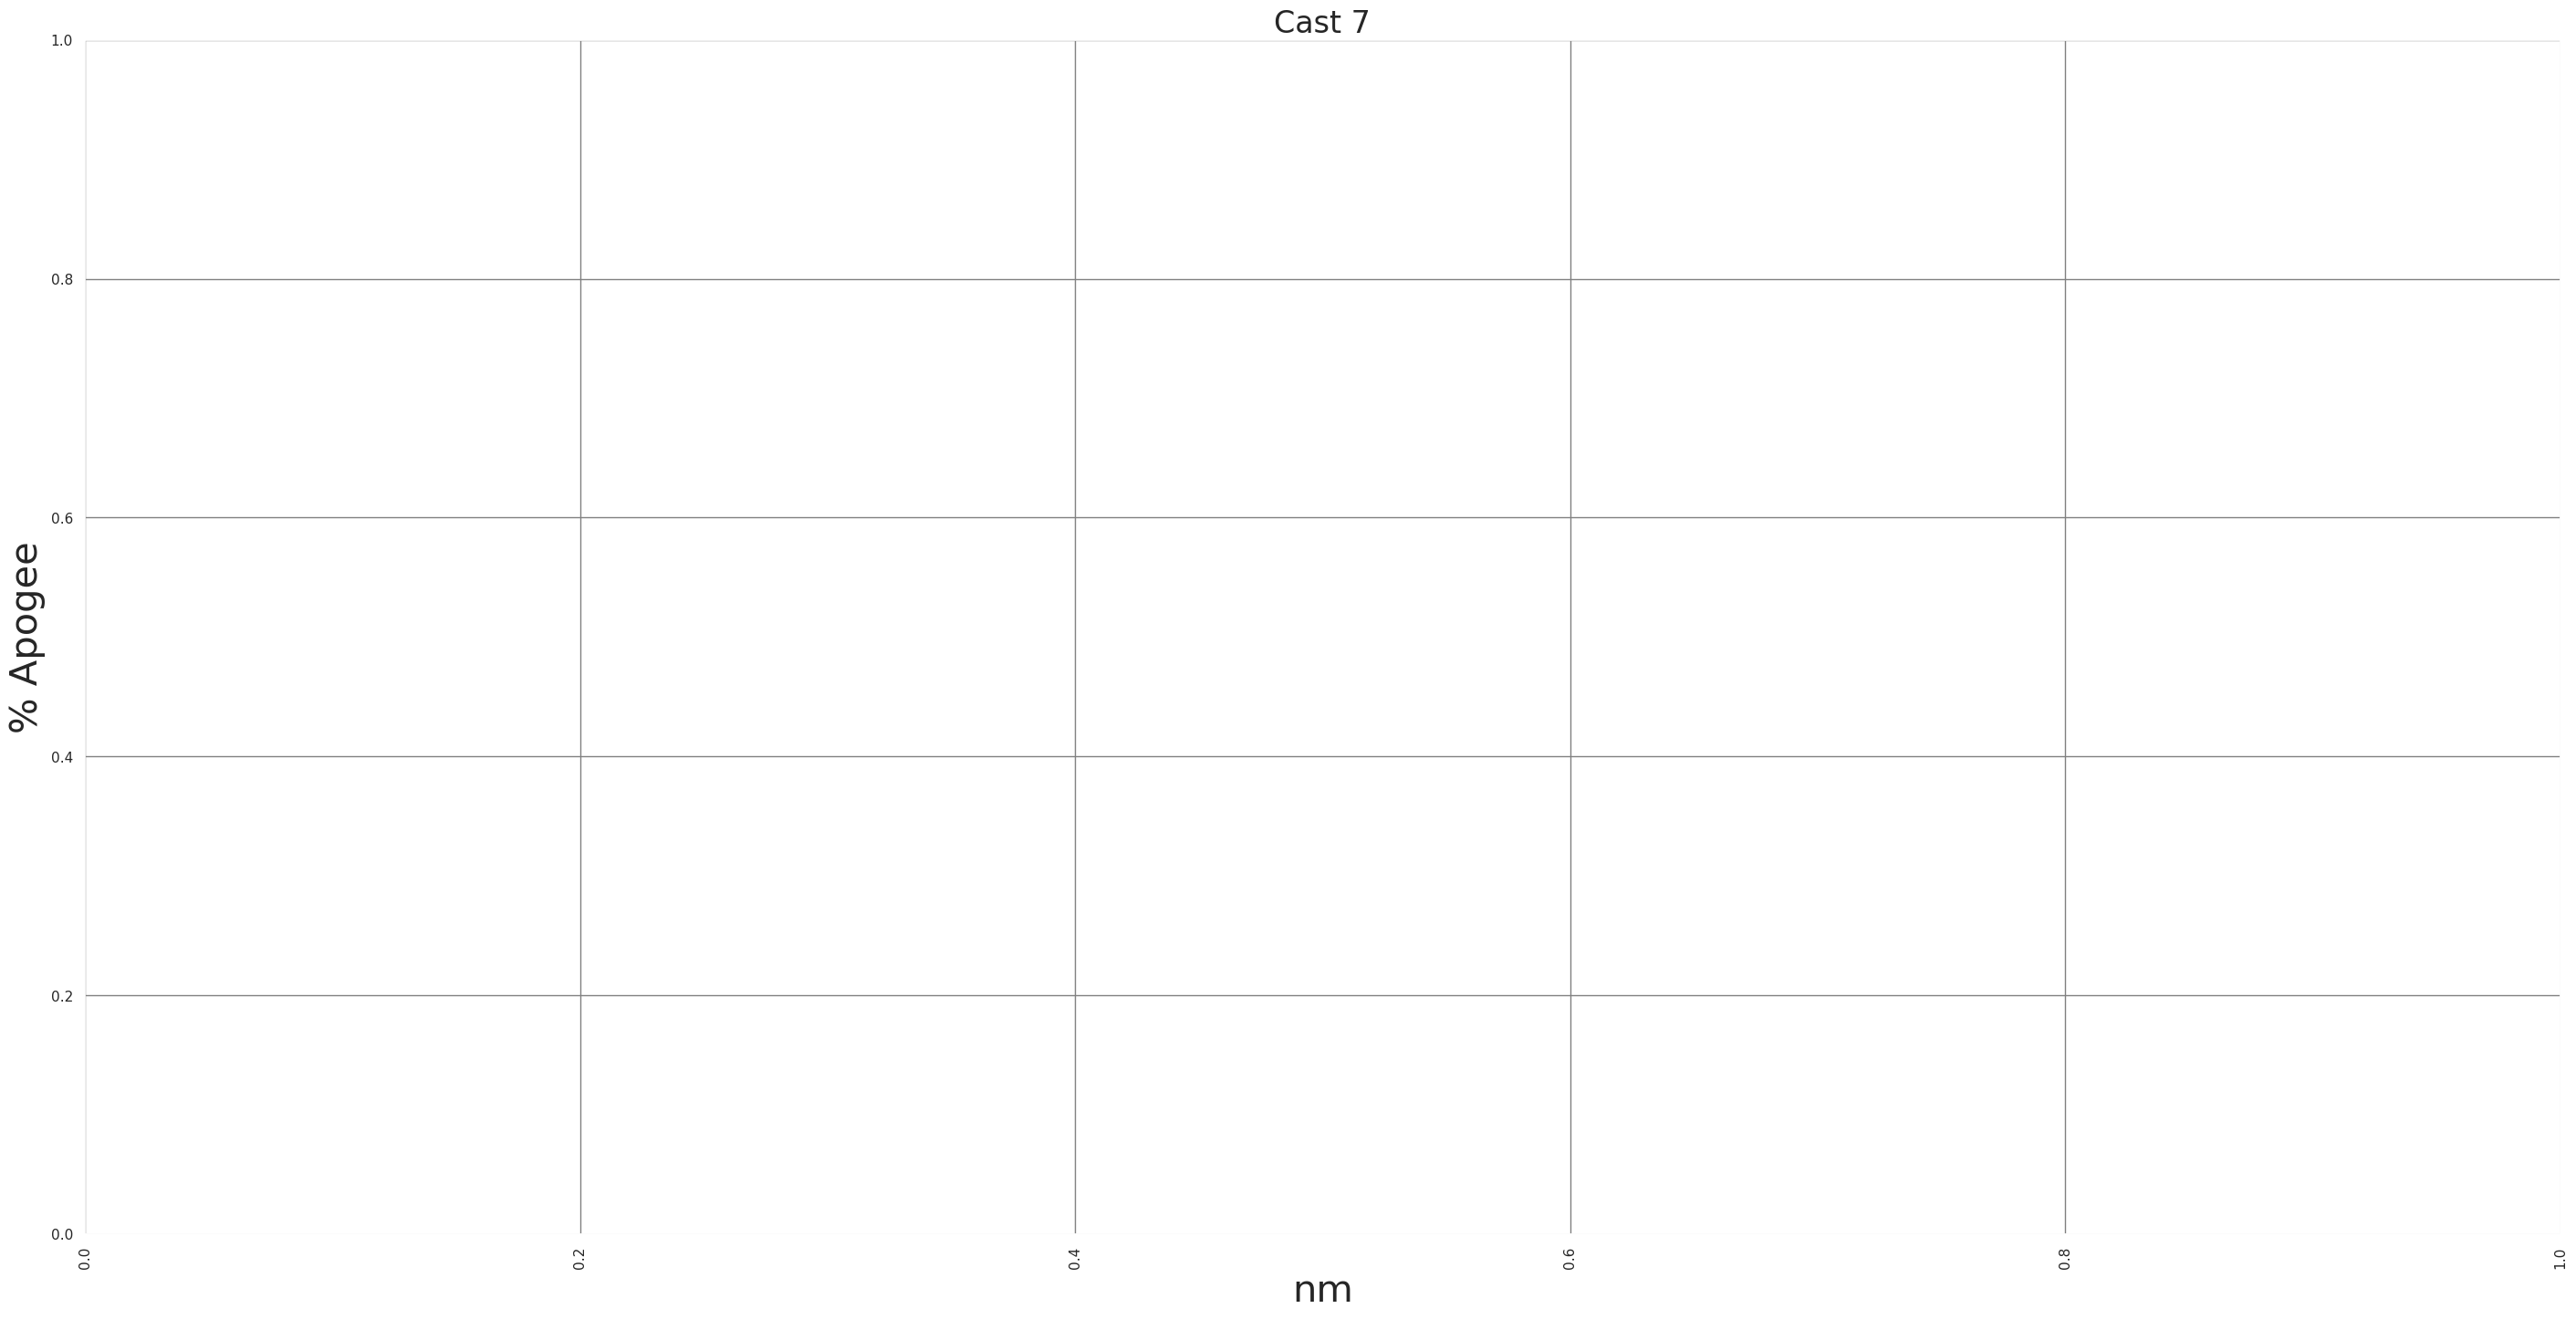

In [2]:
# Visualize curves by depth

tmp = data[data['Cast'] == 'Jezero5']
tmp = tmp[tmp['Sensor'] == 'DW']
tmp = tmp.melt(id_vars=['Meter'], value_vars=curve_columns)

plt.figure(figsize=(35,17))
p = sb.scatterplot(tmp, y='value', x='variable',
               hue='Meter',
               hue_norm=(0,50),
               palette=sb.color_palette("coolwarm", as_cmap=True))
sb.set(font_scale=2)
p.set_xlabel("nm",fontsize=30)
p.set_ylabel("% Apogee",fontsize=30)
plt.xticks(rotation=90)
plt.title("Cast 7")
plt.show()


In [3]:
import warnings
warnings.filterwarnings("ignore")
import random
from tqdm import tqdm
# Find optimal K, solver, distance measure, etc

var = np.array(data[curve_columns]).var()
print(var)
res = []
for seed in tqdm(random.sample(range(1, 10000), 50)):
    for c in [2,3,4,5,6,7,8,9,10]:
        for init in ['nndsvda']:
            for s in ['mu']:
                for l in ['frobenius', 'kullback-leibler']:
                    if s == 'cd' and l == 'kullback-leibler':
                        print("cd and kullback solver cannot go together")
                    else:
                        model = NMF(n_components=c, init=init,
                                    random_state=seed, solver=s,
                                    beta_loss=l, max_iter=1000, verbose=0)
                        W = model.fit_transform(data[curve_columns])
                        H = model.components_
                        AIC = 2*(((model.reconstruction_err_)/(2*var)) + c)
                        res.append(pd.DataFrame([c,init,s,l,model.reconstruction_err_, AIC]).T)

res = pd.concat(res)
res.columns = ['K', 'init', 'solver', 'distance', 'error', 'AIC']

169.31561860684545


  4%|▍         | 2/50 [00:51<20:42, 25.88s/it]


KeyboardInterrupt: 

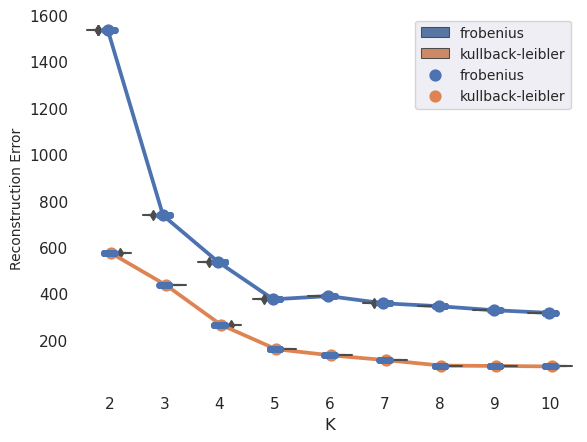

In [88]:
# Plot optimal k

res_f = res#[res['distance'] == 'frobenius']
ax = sb.boxplot(res_f, x='K', y = 'error', hue='distance', boxprops={'alpha': 0.1})
sb.stripplot(data=res_f, x="K", y="error", dodge=True, ax=ax)
sb.pointplot(data=res_f, x="K", y="error", hue="distance", dodge=True, ax=ax)
plt.legend( fontsize="10", loc ="upper right")
plt.ylabel("Reconstruction Error",fontsize="10")
ax.set_facecolor('white')
plt.savefig("nmf.pdf", facecolor=ax.get_facecolor(), transparent=True, dpi=500)
plt.show()



In [3]:
# fitting the model
model = NMF(n_components=5, init='nndsvda', solver='cd',
                                beta_loss='frobenius', max_iter=10000,random_state=7 )
W = model.fit_transform(data[curve_columns])
H = model.components_
np.shape(W)


(5397, 5)

/tmp/ipykernel_9787/1085425203.py:9: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  p = sb.lineplot(tmp, y='value', x='nm',


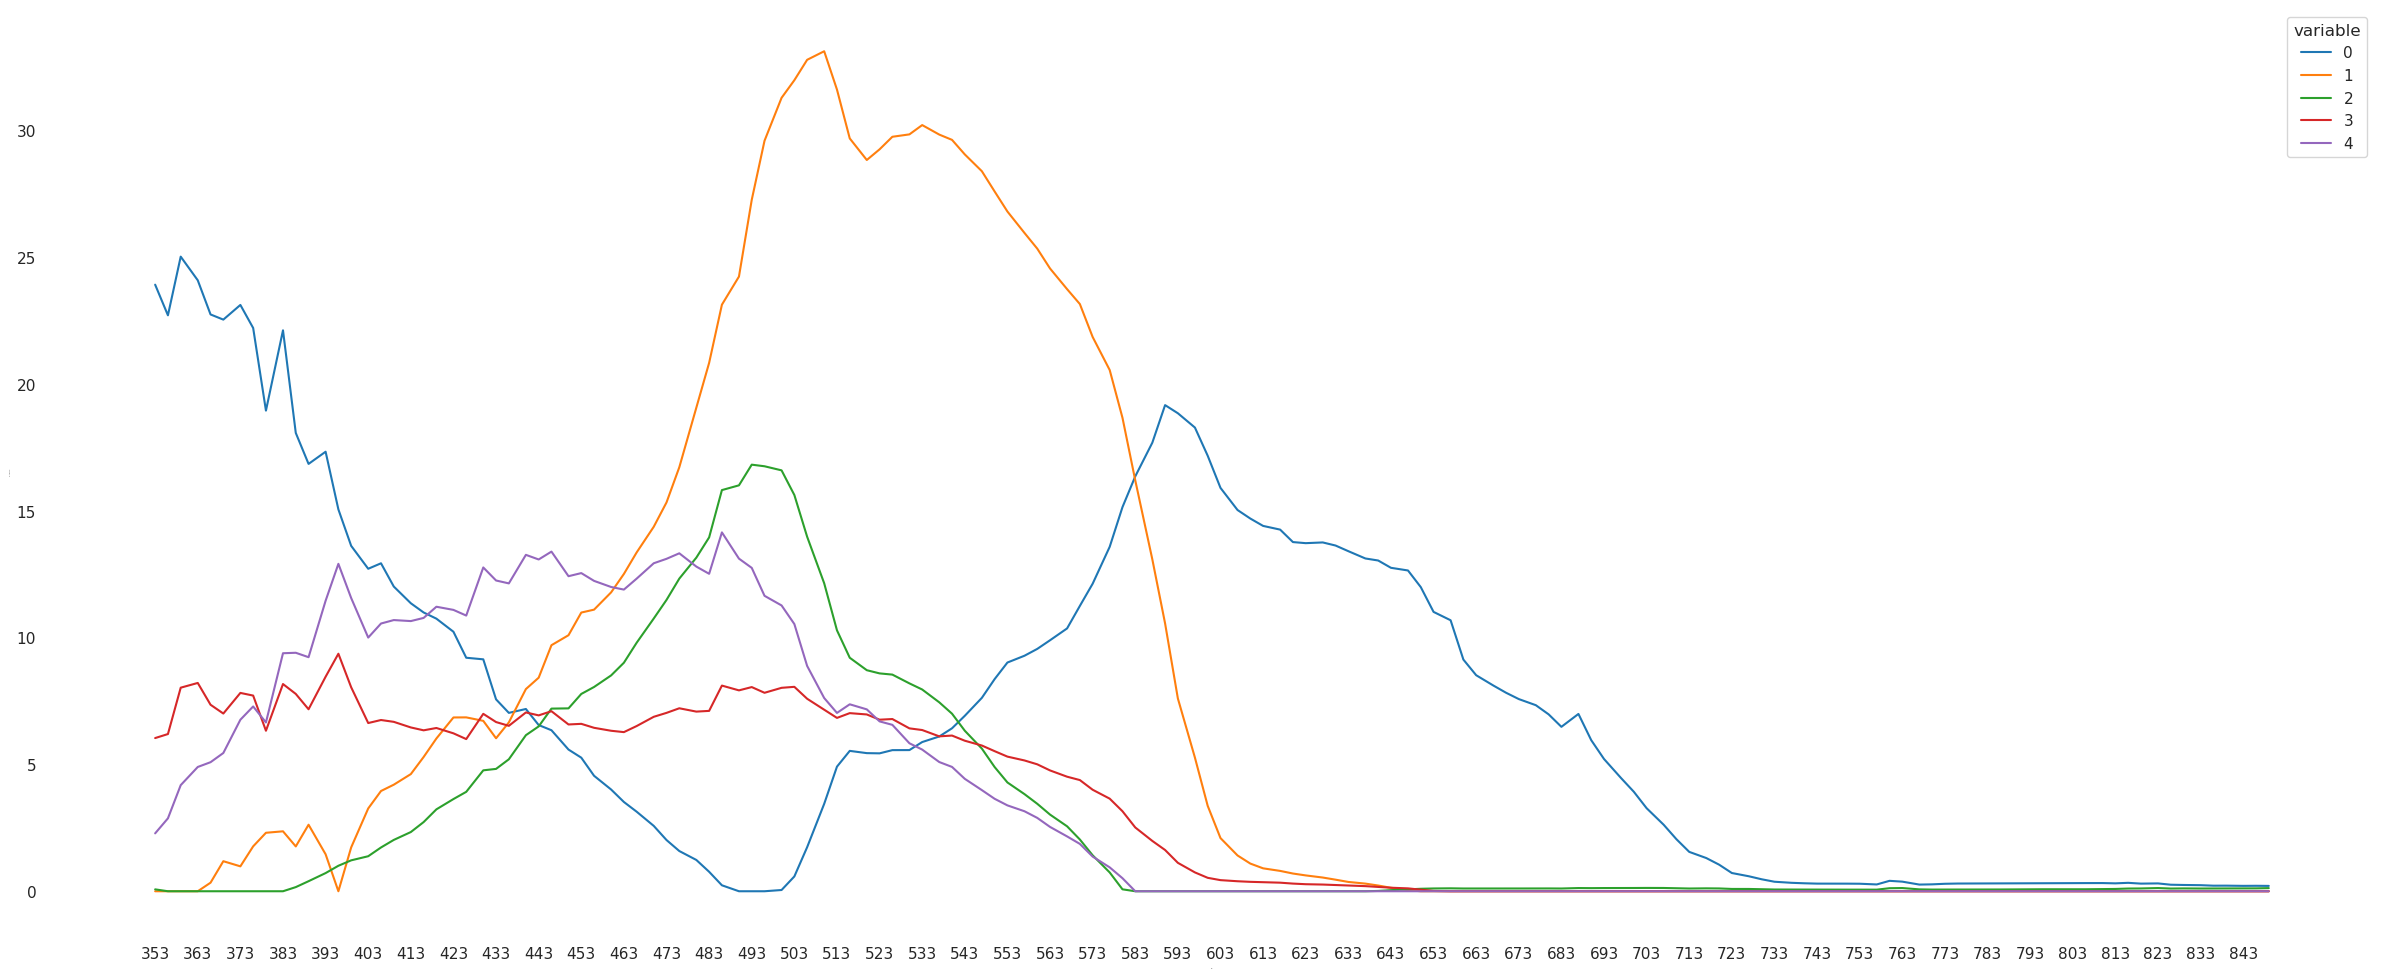

In [4]:
# Plotting the signatures
%matplotlib inline
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
tmp = pd.DataFrame(H).T
tmp['nm'] = curve_columns.values
tmp = tmp.melt(id_vars=['nm'])
plt.figure(figsize=(30,12))
tmp['nm'] = tmp['nm'].astype('float')
p = sb.lineplot(tmp, y='value', x='nm',
               hue='variable',
               palette=sb.color_palette("tab10"))
sb.set(font_scale=1)
p.set_xlabel("nm",fontsize=1)
p.set_ylabel("% Apogee",fontsize=1)
plt.xticks(np.arange(min(tmp['nm']), max(tmp['nm'])+1, 10))
plt.savefig("plots/signatures.pdf", dpi=10)
plt.show()


      Cast Sensor   Meter variable     value
0      6.0     UW  1.2925       S1  0.054389
1      6.0     UW  1.2925       S1  0.061607
2      6.0     UW  1.9137       S1  0.056053
3      6.0     UW  1.9137       S1  0.045266
4      6.0     UW  1.9875       S1  0.050500
...    ...    ...     ...      ...       ...
26980    8     DW  5.1652       S5  0.000000
26981    8     DW  5.1652       S5  0.000000
26982    8     DW  4.4936       S5  0.000000
26983    8     DW  4.2255       S5  0.047471
26984    8     DW  3.4930       S5  0.000000

[26985 rows x 5 columns]


NameError: name 'ax' is not defined

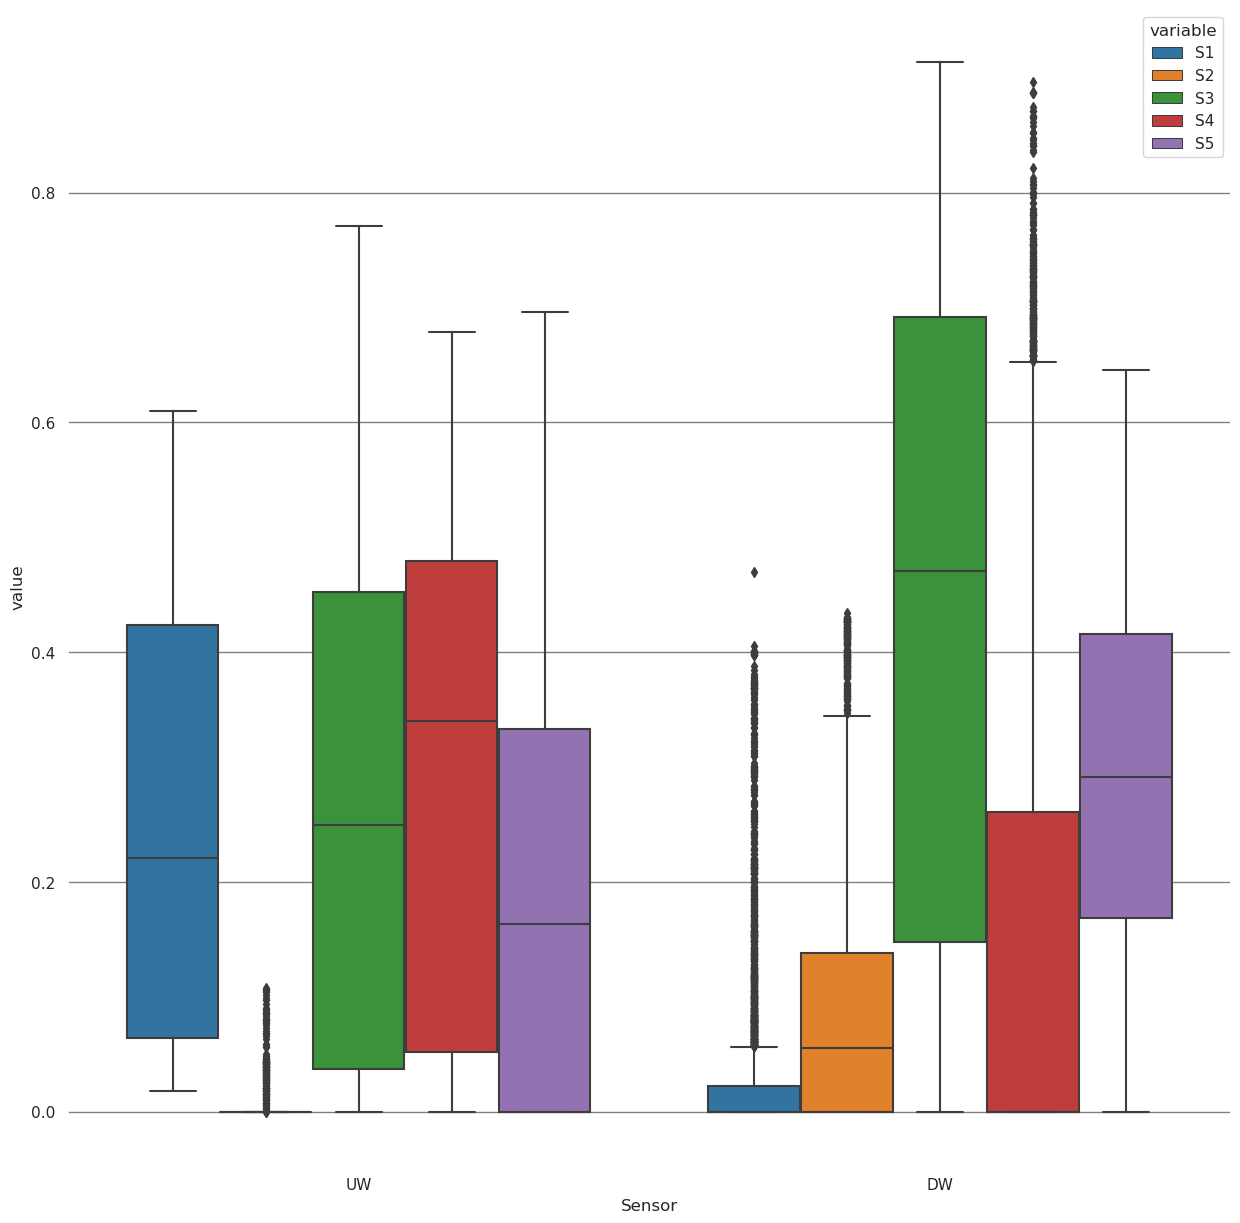

In [30]:
tmp = pd.DataFrame(W)
tmp.columns = ['S1', 'S2', 'S3', 'S4', 'S5']
tmp = ((tmp[['S1', 'S2', 'S3', 'S4', 'S5']].T/tmp.sum(axis=1).values).T)
tmp['Cast'] = data['Cast'].values
tmp['Sensor'] = data['Sensor'].values
tmp['Meter'] = data['Meter'].values


for_plot = tmp.melt(id_vars=['Cast', 'Sensor', 'Meter'])
print(for_plot)
plt.figure(figsize=(15,15))
p = sb.boxplot(for_plot, y='value', x='Sensor',hue='variable',
               palette=sb.color_palette("tab10"))
ax.set_facecolor('white')
plt.savefig("plots/sig_desc.pdf", facecolor=ax.get_facecolor(), transparent=True, dpi=900)
plt.show()



In [66]:
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white','grid.color': 'gray'})
tmp
for_plot_cast6 = tmp.groupby(np.arange(len(tmp)) // 2).agg({'S1':'mean', 'S2':'mean', 'S3': 'mean', 'S4':'mean', 'S5':'mean', 'Sensor':'last', 'Meter':'mean'})
for_plot_cast6 = for_plot_cast6.melt(id_vars=['Sensor', 'Meter'])
for_plot_cast6 = for_plot_cast6[for_plot_cast6['Meter'] > 2]

sb.jointplot(for_plot_cast6.query("variable == 'S1'"), x='value', y = 'Meter',hue='Sensor',kind='kde')
plt.savefig('plots/signatures_depth_S1.pdf',dpi=20)
plt.close()

sb.jointplot(for_plot_cast6.query("variable == 'S2'"), x='value', y = 'Meter',hue='Sensor',kind='kde')
plt.savefig('plots/signatures_depth_S2.pdf',dpi=20)
plt.close()

sb.jointplot(for_plot_cast6.query("variable == 'S3'"), x='value', y = 'Meter',hue='Sensor',kind='kde')
plt.savefig('plots/signatures_depth_S3.pdf',dpi=20)
plt.close()

sb.jointplot(for_plot_cast6.query("variable == 'S4'"), x='value', y = 'Meter',hue='Sensor',kind='kde')
plt.savefig('plots/signatures_depth_S4.pdf',dpi=20)
plt.close()

sb.jointplot(for_plot_cast6.query("variable == 'S5'"), x='value', y = 'Meter',hue='Sensor',kind='kde')
plt.savefig('plots/signatures_depth_S5.pdf',dpi=20)
plt.close()


In [150]:
import glob
import tqdm

'''
Merge all spectra wiz files and make 1 file for each measure(depth)
'''
def make_merged_spectra_wiz(list_of_folders, location):
    for k in tqdm.tqdm(list_of_folders):
        spect_rows = []
        for f in glob.glob("KastelVisExp/{}/ApogeeData/{}/*.IRR".format(location,k)):
            apogee = pd.read_csv("{}".format(f), skiprows=1,sep=' ')
            apogee.columns = ['ignore1', 'nm', 'ignore2', 'value']
            apogee = apogee.drop(columns=['ignore1', 'ignore2'])
            apogee = apogee[apogee['nm'].between(350, 850)].T
            apogee = apogee[apogee.columns[::2]] # take every second column, so I have only round nms
            cols = apogee.head(1).values.tolist()[0]
            cols = [int(c) for c in cols]
            apogee = apogee.tail(1)
            time = f.split("#")[1].split(".")[0].replace("_", ":")
            apogee['TIMETAG2'] = time
            spect_rows.append(apogee)
            spect_data = pd.concat(spect_rows)
            cols.append("TIMETAG2")
            spect_data.columns = cols
            spect_data.to_csv("KastelVisExp/{}/ApogeeData/spectra_merged_{}.csv".format(location, k))

make_merged_spectra_wiz(['K0', 'K5', 'K10', 'K15', 'K20', 'K28'], 'Kastela')
make_merged_spectra_wiz(['V0', 'V5', 'V10', 'V20', 'V30', 'V50', 'V100'], 'Vis')


100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


In [7]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
location = 'Kastela'
'''
This can run for Vis or Kastel so change paramters accordingly.
it runs through folders, loads depth,appoge and experiment data.
In order to merge it some columns needs to be renamed and then checked for common column names
Lastly curve is normalized by appoge and inputed into NMF model from above
'''
vis_folders=[ 'V0','V5', 'V10', 'V20', 'V30', 'V50', 'V100']
kastel_folders = ['K0', 'K5', 'K10', 'K15', 'K20', 'K28']
signatures_in_exp = pd.DataFrame()
for folder in kastel_folders:
    for uw_dw in ['msm_dw', 'msm_uw']:
        if folder ==  '{}0'.format(location[0]):
            DEPTH = 1.8
        else:
            DEPTH = float(folder.split(location[0])[1])
        if folder == 'V100':
            DEPTH = 99
        if uw_dw == 'msm_dw':
            ED_column_start = 'ED(351.96)'
            ED_column_end = 'ED(850.90)'
        else:
            ED_column_start = 'EU(349.92)'
            ED_column_end = 'EU(852.88)'
        depth_file = glob.glob('KastelVisExp/{}/JohnnyFiveSonda/{}/*.asc'.format(location,folder))
        # depth data from experiment
        depth = pd.read_csv(depth_file[0],sep=',',skiprows=10)
        depth.columns = ['temp', 'depth','date', 'TIMETAG2']
        depth['TIMETAG2'] = depth['TIMETAG2'].str.strip()
        depth['TIMETAG2'] = pd.to_datetime(depth['TIMETAG2'])
        # Curve from experiment
        exp_data = pd.read_csv("KastelVisExp/{}/JohnnyFiveSonda/{}/{}.tsv".format(location,folder,uw_dw),sep='\t',skiprows=3)
        exp_data = exp_data.iloc[1::]
        start_index = exp_data.columns.get_loc(ED_column_start)
        end_index = exp_data.columns.get_loc(ED_column_end)
        exp_data.columns = exp_data.columns.str.replace('(', '')
        exp_data.columns = exp_data.columns.str.replace(')','')
        if uw_dw == 'msm_dw':
            exp_data.columns = exp_data.columns.str.replace('ED','')
        else:
            exp_data.columns = exp_data.columns.str.replace('EU','')
        tmp = exp_data.columns.str.split('.',1,expand=True)
        tmp_columns = []
        [tmp_columns.append(c[0]) for c in tmp]
        exp_data.columns = tmp_columns
        #print(exp_data)
        curve_columns = exp_data.columns[start_index:end_index].to_list()
        curve_columns.append('TIMETAG2')
        # take only curve 350-850 + timetag2
        exp_data = exp_data[curve_columns]
        # split time in order to ignore milis
        exp_data[['TIMETAG2', 'milis']] = exp_data['TIMETAG2'].str.split('.',1,expand=True)
        exp_data['TIMETAG2'] = exp_data['TIMETAG2'].str.strip()
        exp_data['TIMETAG2'] = pd.to_datetime(exp_data['TIMETAG2'])

        apogee = pd.read_csv('KastelVisExp/{}/ApogeeData/spectra_merged_{}.csv'.format(location,folder))
        apogee['TIMETAG2'] = pd.to_datetime(apogee['TIMETAG2'])
        common_columns = exp_data.columns.intersection(apogee.columns)
        if folder == 'V0':
            #apogee['TIMETAG2'] = apogee['TIMETAG2'] - pd.Timedelta(hours=0, minutes=23, seconds=0)
            #print(apogee)
            merged = pd.merge_asof(exp_data, apogee.sort_values('TIMETAG2'), on='TIMETAG2',
                                        tolerance=pd.Timedelta('15m'), suffixes=("_CTD", "_apogee"),
                                       direction='nearest', allow_exact_matches=True)
        else:
            merged = pd.merge_asof(exp_data, apogee.sort_values('TIMETAG2'), on='TIMETAG2',
                                        tolerance=pd.Timedelta('2s'), suffixes=("_CTD", "_apogee"),
                                       direction='nearest', allow_exact_matches=True)
        merged = pd.merge_asof(merged, depth.sort_values('TIMETAG2'), on='TIMETAG2',
                                tolerance=pd.Timedelta('2s'),
                               direction='nearest', allow_exact_matches=True)
        merged = merged[merged['depth'].between(DEPTH-0.5, DEPTH+0.5)]
        ctd_columns = merged.columns[merged.columns.str.endswith('CTD')]
        apogee_columns = merged.columns[merged.columns.str.endswith('apogee')]
        merged[ctd_columns] = merged[ctd_columns].apply(pd.to_numeric)
        merged[apogee_columns] = merged[apogee_columns].apply(pd.to_numeric)
        normalized_curve = pd.DataFrame((merged[ctd_columns].values/(merged[apogee_columns].values+1)) *100)
        normalized_curve[normalized_curve < 0] = 0
        normalized_curve.mean(axis=0).to_csv('{}_{}_{}.csv'.format(location,folder,uw_dw))
        res = model.transform(normalized_curve)
        res = res.mean(axis=0)
        res = res/res.sum()
        row = {'sample': folder,'depth':DEPTH, 'UW_DW': uw_dw, 'S1': res[0], 'S2':res[1], 'S3':res[2], 'S4': res[3], 'S5':res[4]}
        print(row)
        signatures_in_exp = pd.concat([signatures_in_exp, pd.DataFrame([row])], axis=0,ignore_index=True)

signatures_in_exp

/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K0', 'depth': 1.8, 'UW_DW': 'msm_dw', 'S1': 0.42915387318073933, 'S2': 0.12467112858568095, 'S3': 0.358518669419981, 'S4': 0.0, 'S5': 0.08765632881359865}
{'sample': 'K0', 'depth': 1.8, 'UW_DW': 'msm_uw', 'S1': 0.49913346226924515, 'S2': 0.0, 'S3': 0.500866537730755, 'S4': 0.0, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K5', 'depth': 5.0, 'UW_DW': 'msm_dw', 'S1': 0.4508810685275794, 'S2': 0.07419235395612957, 'S3': 0.4115368013286444, 'S4': 0.0029942870078874637, 'S5': 0.06039548917975924}
{'sample': 'K5', 'depth': 5.0, 'UW_DW': 'msm_uw', 'S1': 0.11229644781630942, 'S2': 0.03835025316364061, 'S3': 0.405979089853172, 'S4': 0.3903759385095394, 'S5': 0.05299827065733862}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K10', 'depth': 10.0, 'UW_DW': 'msm_dw', 'S1': 0.15349011289872438, 'S2': 0.34229391770850515, 'S3': 0.08476455876881667, 'S4': 6.009506350889407e-05, 'S5': 0.41939131556044484}
{'sample': 'K10', 'depth': 10.0, 'UW_DW': 'msm_uw', 'S1': 0.08011968683630813, 'S2': 0.012083878903583384, 'S3': 0.5728244967584061, 'S4': 0.3018604760383521, 'S5': 0.03311146146335041}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K15', 'depth': 15.0, 'UW_DW': 'msm_dw', 'S1': 0.021277875040328284, 'S2': 0.2757253248850267, 'S3': 0.2728486400100552, 'S4': 0.09047048967318551, 'S5': 0.33967767039140434}
{'sample': 'K15', 'depth': 15.0, 'UW_DW': 'msm_uw', 'S1': 0.0902634825748433, 'S2': 0.0009725195470088215, 'S3': 0.6687525919510111, 'S4': 0.2400114059271366, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


{'sample': 'K20', 'depth': 20.0, 'UW_DW': 'msm_dw', 'S1': 0.03503621983876426, 'S2': 0.17174705557975425, 'S3': 0.5905252491396668, 'S4': 0.07483650489901746, 'S5': 0.12785497054279732}
{'sample': 'K20', 'depth': 20.0, 'UW_DW': 'msm_uw', 'S1': 0.3672690797540627, 'S2': 0.0, 'S3': 0.5934446917548047, 'S4': 0.03928622849113253, 'S5': 0.0}
{'sample': 'K28', 'depth': 28.0, 'UW_DW': 'msm_dw', 'S1': 0.1174511204726069, 'S2': 0.08933479729581098, 'S3': 0.7932140822315821, 'S4': 0.0, 'S5': 0.0}
{'sample': 'K28', 'depth': 28.0, 'UW_DW': 'msm_uw', 'S1': 0.4677524431576035, 'S2': 0.0, 'S3': 0.5322475568423964, 'S4': 0.0, 'S5': 0.0}


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


,sample,depth,UW_DW,S1,S2,S3,S4,S5
0,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
2,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
3,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
4,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
5,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111
6,K15,15.0,msm_dw,0.021278,0.275725,0.272849,0.090470,0.339678
7,K15,15.0,msm_uw,0.090263,0.000973,0.668753,0.240011,0.000000
8,K20,20.0,msm_dw,0.035036,0.171747,0.590525,0.074837,0.127855
9,K20,20.0,msm_uw,0.367269,0.000000,0.593445,0.039286,0.000000


In [6]:
all_curves = pd.DataFrame()
curve_columns = curve_columns[1:-1]
print(curve_columns[2:-2])
for f in glob.glob("KastelVisExp/experimentCurves/*.csv"):
    print(f)
    parts = f.split('_')
    curve = pd.read_csv(f)
    curve.columns = ['nm', 'value']
    curve['nm'] = curve_columns
    curve['nm']= curve['nm'].astype('float')
    curve['location'] = parts[0]
    curve['sample'] = parts[1]
    curve['UW_DW'] = parts[3].split('.')[0]
    all_curves = pd.concat([all_curves, curve])

print(all_curves)
vis_curves = all_curves
sb.pointplot(all_curves, x = 'nm', y = 'value', hue='sample')

['359', '363', '366', '369', '373', '376', '379', '383', '386', '389', '393', '396', '399', '403', '406', '409', '413', '416', '419', '423', '426', '430', '433', '436', '440', '443', '446', '450', '453', '456', '460', '463', '466', '470', '473', '476', '480', '483', '486', '490', '493', '496', '500', '503', '506', '510', '513', '516', '520', '523', '526', '530', '533', '537', '540', '543', '547', '550', '553', '557', '560', '563', '567', '570', '573', '577', '580', '583', '587', '590', '593', '597', '600', '603', '607', '610', '613', '617', '620', '623', '627', '630', '633', '637', '640', '643', '647', '650', '653', '657', '660', '663', '667', '670', '673', '677', '680', '683', '687', '690', '693', '697', '700', '703', '707', '710', '713', '717', '720', '723', '727', '730', '733', '737', '740', '743', '747', '750', '753', '757', '760', '763', '767', '770', '773', '776', '780', '783', '786', '790', '793', '796', '800', '803', '806', '810', '813', '816', '819', '823', '826', '829', '833'

ValueError: Length of values (150) does not match length of index (148)

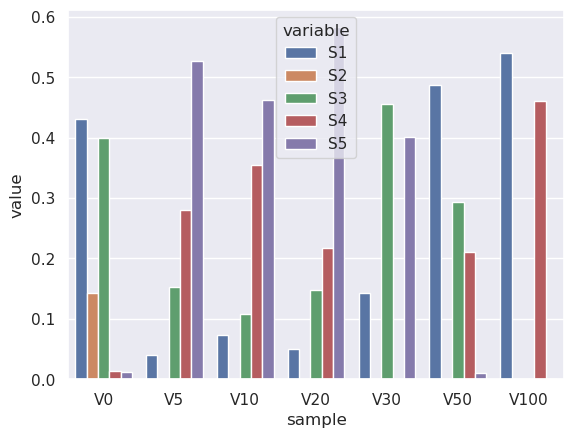

In [7]:
for_plot = signatures_in_exp.melt(id_vars=['sample','depth','UW_DW'])
for_plotDW = for_plot[for_plot['UW_DW'] == 'msm_dw'].copy()
sb.barplot(for_plotDW, x='sample', y ='value', hue='variable')
plt.savefig('signatures_in_{}_dw.pdf'.format(location),dpi=20)
plt.close()
for_plotUW = for_plot[for_plot['UW_DW'] == 'msm_uw'].copy()
sb.barplot(for_plotUW, x='sample', y ='value', hue='variable')
plt.savefig('signatures_in_{}_uw.pdf'.format(location),dpi=20)

In [8]:
#signatures_in_exp_Vis = signatures_in_exp
signatures_in_exp_Kastela = signatures_in_exp

In [9]:
signatures_in_both = pd.concat([signatures_in_exp_Vis,signatures_in_exp_Kastela])
signatures_in_both

,sample,depth,UW_DW,S1,S2,S3,S4,S5
0,V0,1.8,msm_dw,0.421611,0.121317,0.341025,0.027584,0.088462
1,V0,1.8,msm_uw,0.430734,0.143169,0.399917,0.014184,0.011996
2,V5,5.0,msm_dw,0.254787,0.106228,0.222920,0.314442,0.101623
3,V5,5.0,msm_uw,0.040229,0.000000,0.152842,0.279948,0.526981
4,V10,10.0,msm_dw,0.144992,0.113122,0.177536,0.361932,0.202419
5,V10,10.0,msm_uw,0.073765,0.000000,0.108759,0.355546,0.461931
6,V20,20.0,msm_dw,0.017038,0.065719,0.183818,0.468681,0.264743
7,V20,20.0,msm_uw,0.050898,0.000000,0.148149,0.218070,0.582883
8,V30,30.0,msm_dw,0.000292,0.056878,0.415715,0.163462,0.363653
9,V30,30.0,msm_uw,0.143436,0.000000,0.455977,0.000000,0.400587


In [25]:
cyano_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
cyano_data = cyano_data.merge(signatures_in_both, left_on='Station', right_on='sample')
cyano_data

,Station,Location,WhoDidIt,depth_x,PP_LSR,EOC_LSR,EOC/POC_LSR,PPSplit,EOC/PP_LSR,Chla,...,bacteria,%HNA bacteria,sample,depth_y,UW_DW,S1,S2,S3,S4,S5
0,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
2,K0,Kastela,Split,0,0.19,2.04,10.65,0.080,1064.644970,NaN,...,NaN,NaN,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
3,K0,Kastela,Split,0,0.19,2.04,10.65,0.080,1064.644970,NaN,...,NaN,NaN,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
4,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
5,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
6,K5,Kastela,Split,5,0.37,2.51,6.70,0.060,669.681083,NaN,...,NaN,NaN,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
7,K5,Kastela,Split,5,0.37,2.51,6.70,0.060,669.681083,NaN,...,NaN,NaN,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
8,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
9,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111


In [26]:
tmp= cyano_data[['S1','S2','S3','S4','S5','UW_DW','Location', 'Synechococcus','bacteria','heterotrofic nanoflagellates', 'picoeukaryotes', 'Prochlorococcus','Chla']]
print(cyano_data)
tmp_uw = tmp.query("Location == 'Kastela' and UW_DW == 'msm_dw'")
plt.figure(figsize=(16, 16))
mask = np.triu(np.ones_like(tmp_uw.corr()))
sb.heatmap(tmp_uw.corr(),annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True),mask=mask )
plt.savefig('plots/cyano_by_signatures_Kastela_dw.pdf',dpi=20)
plt.close()
tmp_uw = tmp.query("Location == 'Vis' and UW_DW == 'msm_dw'")
plt.figure(figsize=(16, 16))
mask = np.triu(np.ones_like(tmp_uw.corr()))
sb.heatmap(tmp_uw.corr(),annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True),mask=mask )
plt.savefig('plots/cyano_by_signatures_Vis_dw.pdf',dpi=20)
plt.close()

   Station Location WhoDidIt  depth_x  PP_LSR  EOC_LSR  EOC/POC_LSR  PPSplit  \
0       K0  Kastela  Marinix        0    4.25     2.52         0.59    3.260   
1       K0  Kastela  Marinix        0    4.25     2.52         0.59    3.260   
2       K0  Kastela    Split        0    0.19     2.04        10.65    0.080   
3       K0  Kastela    Split        0    0.19     2.04        10.65    0.080   
4       K5  Kastela  Marinix        5    4.06     2.88         0.71    1.050   
5       K5  Kastela  Marinix        5    4.06     2.88         0.71    1.050   
6       K5  Kastela    Split        5    0.37     2.51         6.70    0.060   
7       K5  Kastela    Split        5    0.37     2.51         6.70    0.060   
8      K10  Kastela  Marinix       10    0.91     2.73         3.01    0.890   
9      K10  Kastela  Marinix       10    0.91     2.73         3.01    0.890   
10     K10  Kastela    Split       10    0.33     2.28         7.00    0.040   
11     K10  Kastela    Split       10   

In [27]:
tmp = cyano_data[['Synechococcus','bacteria','heterotrofic nanoflagellates', 'picoeukaryotes','Prochlorococcus','depth_x', 'Station']]
tmp_uw = tmp#[tmp['Station'].str.startsWI == 'msm_uw']
tmp_uw = tmp_uw.melt(id_vars=['Station', 'depth_x'])
print(tmp_uw)

sb.lmplot(tmp_uw, x='depth_x', y='value', hue='variable',ci=None,order=1)
plt.savefig('plots/correlation_depth_cyanos_UW.pdf', dpi=20)
plt.close()
tmp_dw = tmp#[tmp['Station'] == 'msm_dw']
tmp_dw = tmp_dw.melt(id_vars=['Station', 'depth_x'])
for_corr = tmp_dw.dropna()
syne = for_corr.query("variable == 'Synechococcus'")
procho = for_corr.query("variable == 'Prochlorococcus'")
r = scipy.stats.pearsonr(x=syne['depth_x'], y=syne['value'])
r2 = scipy.stats.pearsonr(x=procho['depth_x'], y=procho['value'])
sb.lmplot(tmp_dw, x='depth_x', y='value', hue='variable',ci=None,order=1)
plt.text(1, 3, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.text(1, 5, 'r = {}, P = {}'.format(round(r2.statistic,2),r2.pvalue))
plt.savefig('plots/correlation_depth_cyanos_DW.pdf', dpi=20)
plt.close()

NameError: name 'cyano_data' is not defined

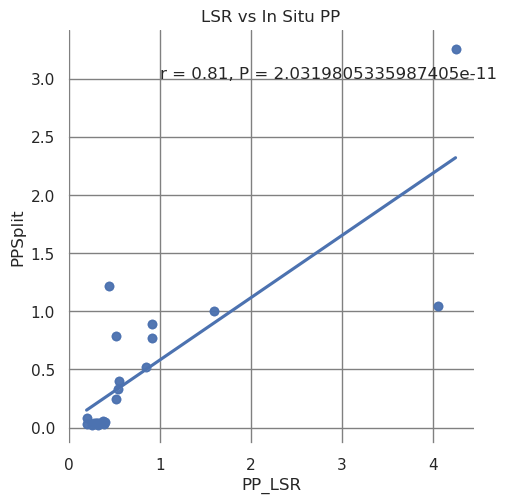

In [28]:
'''
Are we measuring the same primary productivty as split? Yes
But they are often measuring smaller.
'''
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'gray'})
import scipy
for_cor = cyano_data[['PP_LSR', 'PPSplit']].dropna()
r = scipy.stats.pearsonr(x=for_cor['PP_LSR'], y=for_cor['PPSplit'])
tmp = cyano_data
g = sb.lmplot(x='PP_LSR', y='PPSplit', data=cyano_data,ci=False)
plt.text(1, 3, 'r = {}, P = {}'.format(round(r.statistic,2),r.pvalue))
plt.title('LSR vs In Situ PP')
plt.savefig('plots/insitu_vs_lsr_pp.pdf',dpi=10)

In [114]:
productivty = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet2.csv")
#productivty = productivty.merge(signatures_in_both, left_on='Station', right_on='sample')
productivty

,LSR Socket,Station,Location,uW/cm2,POC(dpm),EOC(dpm),POC(PPP),EOC(DPP),EOC/POC
0,1,K0,Kastela,23500.0,9720.0,5780.0,4.250,2.52,0.594
1,2,K0,Kastela,22000.0,8850.0,4890.0,3.870,2.14,0.553
2,3,K0,Kastela,22900.0,8460.0,5010.0,3.700,2.19,0.592
3,4,K0,Kastela,13300.0,9560.0,5210.0,4.180,2.28,0.545
4,5,K0,Kastela,11900.0,10100.0,4960.0,4.410,2.17,0.491
...,...,...,...,...,...,...,...,...,...
163,8,V100,Vis,82.0,1040.0,12600.0,0.414,5.02,12.100
164,9,V100,Vis,56.0,767.0,11700.0,0.306,4.68,15.300
165,10,V100,Vis,52.0,646.0,12000.0,0.258,4.78,18.600
166,11,V100,Vis,0.0,1310.0,10900.0,0.523,4.36,8.340


/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


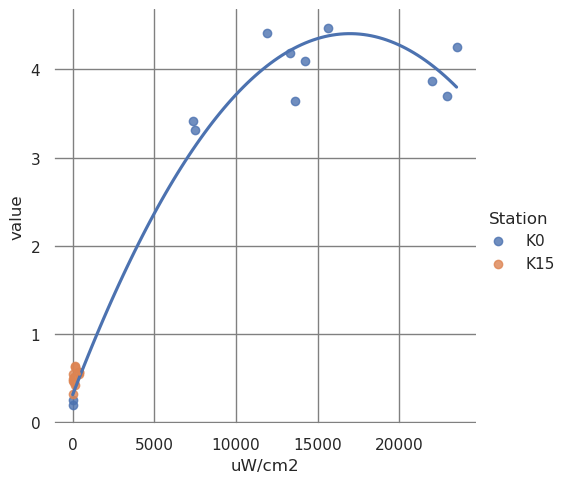

In [133]:

for var in ['EOC/POC', 'POC(PPP)', 'EOC(DPP)']:
    for f in vis_folders + kastel_folders:
        tmp = productivty.melt(id_vars=['Station','LSR Socket','Location', 'uW/cm2'])

        tmp = tmp[tmp['variable'].isin([var])] # 'POC(PPP)', 'EOC(DPP)'
        tmp['LSR Socket'] = tmp['LSR Socket'].astype('category')
        sb.lmplot(
            data=tmp.query("Station == '{}'".format(f)),
            x="uW/cm2", y="value", ci = False, hue='variable',order=2,
            sharex=False,sharey=False
        )
        if var == 'EOC/POC':
            plt.savefig('plots/eoc_poc/EOC_POC_{}.pdf'.format(f), dpi=10)
        else:
            plt.savefig('plots/eoc_poc/{}_{}.pdf'.format(var,f), dpi=10)

/tmp/ipykernel_17776/3072537991.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['value'] = np.log10(tmp['value'] + 1)


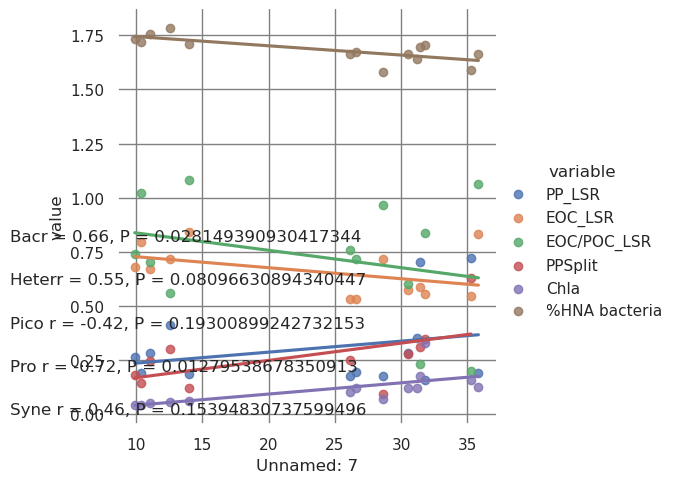

In [184]:
primaryprod = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet3.csv")

# sb.pairplot(primaryprod)
# plt.savefig("plots/all_corss.pdf", dpi=100)

# sb.heatmap(primaryprod.corr(),annot=False,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True))
# plt.savefig('plots/all_cors_f4.pdf', dpi = 200)


for_cor = primaryprod.dropna()
r1 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['PP_LSR'])
r2 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['EOC_LSR'])
r3 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['EOC/POC_LSR'])
r4 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['PPSplit'])
r5 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['Chla'])
r6 = scipy.stats.pearsonr(x=for_cor['Unnamed: 7'], y=for_cor['%HNA bacteria'])

for_plot = primaryprod.melt(id_vars=['Station','depth', 'Unnamed: 7'])
tmp = for_plot[for_plot['variable'].isin(['PP_LSR', 'EOC_LSR', 'EOC/POC_LSR', 'PPSplit', 'Chla', '%HNA bacteria'])]
tmp['value'] = np.log10(tmp['value'] + 1)
sb.lmplot(tmp, x= 'Unnamed: 7', y='value', ci=False, hue = 'variable')
plt.text(10, 0, 'Syne r = {}, P = {}'.format(round(r1.statistic,2),r1.pvalue))
plt.text(10, 0.2, 'Pro r = {}, P = {}'.format(round(r2.statistic,2),r2.pvalue))
plt.text(10, 0.4, 'Pico r = {}, P = {}'.format(round(r3.statistic,2),r3.pvalue))
plt.text(10, 0.6, 'Heterr = {}, P = {}'.format(round(r4.statistic,2),r4.pvalue))
plt.text(10, 0.8, 'Bacr = {}, P = {}'.format(round(r5.statistic,2),r5.pvalue))
#plt.text(0.5, 1, '% r = {}, P = {}'.format(round(r6.statistic,2),r6.pvalue))
plt.savefig('plots/syne_proch_pico_sum_cyano_corrs.pdf',dpi=20)

In [374]:
cyano_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
cyano_data = cyano_data.merge(signatures_in_both, left_on='Station', right_on='sample')
cyano_data = cyano_data[cyano_data['WhoDidIt'] == 'Marinix']
cyano_data

,Station,Location,WhoDidIt,depth_x,PP_LSR,EOC_LSR,EOC/POC_LSR,PPSplit,EOC/PP_LSR,Chla,...,bacteria,%HNA bacteria,sample,depth_y,UW_DW,S1,S2,S3,S4,S5
0,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_dw,0.429154,0.124671,0.358519,0.000000,0.087656
1,K0,Kastela,Marinix,0,4.25,2.52,0.59,3.260,59.416995,0.44,...,0.31359,37.906183,K0,1.8,msm_uw,0.499133,0.000000,0.500867,0.000000,0.000000
4,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_dw,0.450881,0.074192,0.411537,0.002994,0.060395
5,K5,Kastela,Marinix,5,4.06,2.88,0.71,1.050,70.945294,0.50,...,0.54304,48.416323,K5,5.0,msm_uw,0.112296,0.038350,0.405979,0.390376,0.052998
8,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_dw,0.153490,0.342294,0.084765,0.000060,0.419391
9,K10,Kastela,Marinix,10,0.91,2.73,3.01,0.890,300.852010,0.33,...,0.54164,45.116683,K10,10.0,msm_uw,0.080120,0.012084,0.572824,0.301860,0.033111
12,K15,Kastela,Marinix,15,0.57,2.41,4.23,NaN,423.273657,0.33,...,0.51039,46.150983,K15,15.0,msm_dw,0.021278,0.275725,0.272849,0.090470,0.339678
13,K15,Kastela,Marinix,15,0.57,2.41,4.23,NaN,423.273657,0.33,...,0.51039,46.150983,K15,15.0,msm_uw,0.090263,0.000973,0.668753,0.240011,0.000000
16,K20,Kastela,Marinix,20,0.51,2.39,4.73,0.790,472.755418,0.27,...,0.48276,45.169442,K20,20.0,msm_dw,0.035036,0.171747,0.590525,0.074837,0.127855
17,K20,Kastela,Marinix,20,0.51,2.39,4.73,0.790,472.755418,0.27,...,0.48276,45.169442,K20,20.0,msm_uw,0.367269,0.000000,0.593445,0.039286,0.000000


In [391]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression



for dw_uw in ['msm_dw', 'msm_uw']:
    for y in ['Prochlorococcus', 'Synechococcus', 'picoeukaryotes', 'heterotrofic nanoflagellates', 'bacteria', '%HNA bacteria']:
        tmp = cyano_data[cyano_data['UW_DW'] == dw_uw].copy()
        X = tmp[['S1', 'S2', 'S3','S4', 'S5', 'depth_x']].values
        Y = tmp[y].values
        reg = LinearRegression(copy_X=True).fit(X, Y)
        print("RMSE:",np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))))
        tmp['predicted_{}'.format(y)] = reg.predict(X)
        sb.lmplot(tmp, x=y, y='predicted_{}'.format(y), ci=False)
        if y == 'heterotrofic nanoflagellates':
            plt.text(min(Y),min(reg.predict(X)), dw_uw)
            plt.text(min(Y),min(reg.predict(X))+0.1, [round(i,2) for i in reg.coef_])
            plt.text(min(Y),min(reg.predict(X))+0.2, "RMSE = {}".format(round(np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))), 2)))
        else:
            plt.text(min(Y),min(reg.predict(X)), dw_uw)
            plt.text(min(Y),min(reg.predict(X))+1, [round(i,2) for i in reg.coef_])
            plt.text(min(Y),min(reg.predict(X))+2, "RMSE = {}".format(round(np.sqrt(metrics.mean_squared_error(Y, reg.predict(X))), 2)))
        plt.savefig('plots/predicted_{}_{}.pdf'.format(y,dw_uw), dpi=50)
        plt.close()

RMSE: 1.266627633907176
RMSE: 4.540673090593326
RMSE: 0.3915296923509522
RMSE: 0.03764698409713251
RMSE: 0.08193657495987741
RMSE: 4.743717218458206
RMSE: 0.8904746485941701
RMSE: 2.498452386481796
RMSE: 0.4017962733480605
RMSE: 0.06449821614468437
RMSE: 0.06244589265535794
RMSE: 3.1681469831179503


/tmp/ipykernel_9210/2109509324.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  abs = pd.read_csv("KastelVisExp/AbsKrivulje/{}.ABS".format(v),sep="  ", skiprows=2)
/tmp/ipykernel_9210/2109509324.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  abs = pd.read_csv("KastelVisExp/AbsKrivulje/{}.ABS".format(v),sep="  ", skiprows=2)
/tmp/ipykernel_9210/2109509324.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


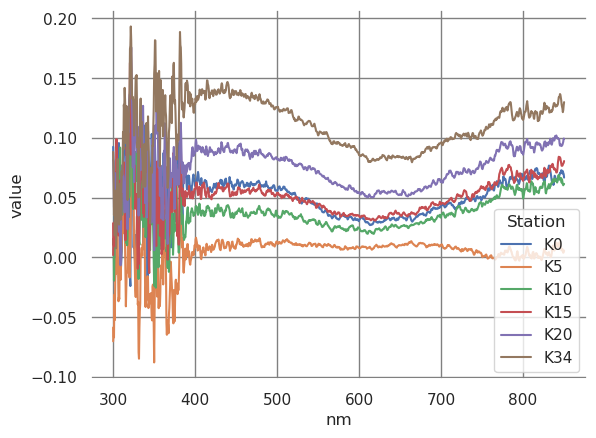

In [23]:
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'gray'})
total = pd.DataFrame()
for v in kastel_folders:
    if v == 'K28':
        v = 'K34'
    abs = pd.read_csv("KastelVisExp/AbsKrivulje/{}.ABS".format(v),sep="  ", skiprows=2)
    abs.columns = ['nm', 'value']
    abs = abs[abs['nm'].between(300,850)]
    abs['Station'] = v
    total = pd.concat([total, abs])

sb.lineplot(total, x = 'nm', y = 'value', hue = 'Station')
plt.savefig('plots/abs_kastel.pdf',dpi=20)

    DepSM  Temperature   Salinity         Station
0     1.0    22.274333  34.463978         Kastela
1     2.5    21.762333  35.133511         Kastela
2     4.0    20.360622  36.234389         Kastela
3     5.5    19.049711  37.143322         Kastela
4     7.0    18.547033  37.392156         Kastela
..    ...          ...        ...             ...
86   93.5    15.251381  38.860067  Stoncica – Vis
87   95.0    15.248776  38.861590  Stoncica – Vis
88   96.5    15.244490  38.863629  Stoncica – Vis
89   98.0    15.239981  38.865476  Stoncica – Vis
90   99.5    15.237558  38.866281  Stoncica – Vis

[91 rows x 4 columns]


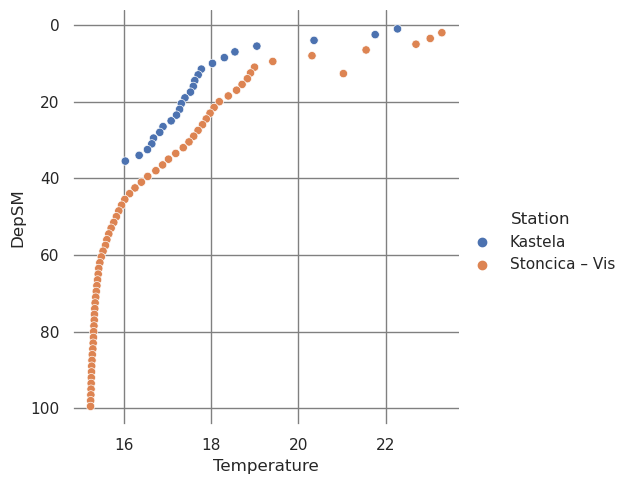

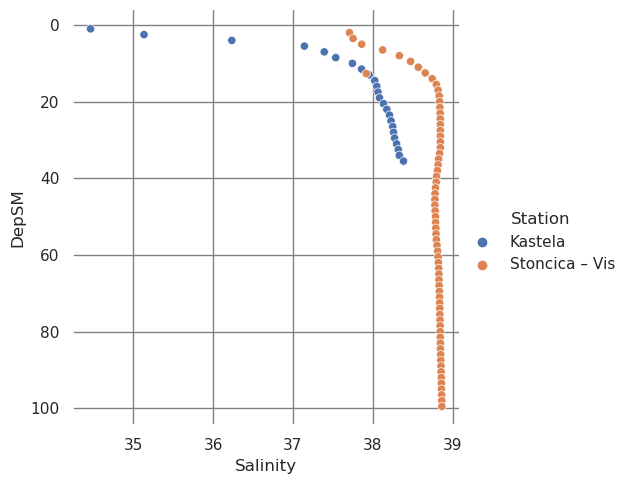

In [100]:
temp_salinitet = pd.read_excel("KastelVisExp/Podatci_Kastela_Stoncica_uredjedno.xlsx", sheet_name="Mateo")
temp_salinitet= temp_salinitet.groupby((temp_salinitet.index)//3).agg({'DepSM':'mean','Temperature':'mean','Salinity':'mean', 'Station': 'last'})
print(temp_salinitet)
p=sb.relplot(data=temp_salinitet, x = 'Temperature', y = 'DepSM', hue = 'Station')
plt.gca().invert_yaxis()
plt.savefig('plots/temp.pdf', dpi=20)
plt.show()
sb.relplot(data=temp_salinitet, x = 'Salinity', y = 'DepSM', hue = 'Station')
plt.gca().invert_yaxis()
plt.savefig('plots/salinity.pdf', dpi=20)

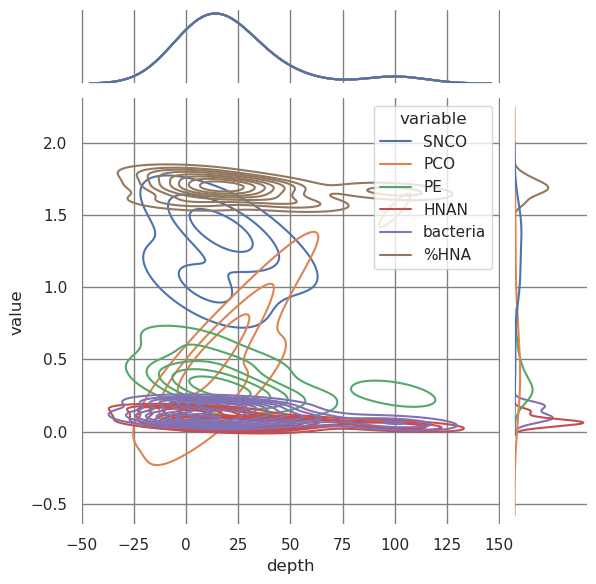

In [24]:
cyano_by_detph = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet4.csv")
cyano_by_detph = cyano_by_detph.melt(id_vars=['depth', 'Station', 'Location'])
cyano_by_detph['value'] = np.log10(cyano_by_detph['value'] + 1)
sb.jointplot(cyano_by_detph.query("variable != 'Chla'"), x = 'depth', y = 'value', hue = 'variable',kind='kde')
plt.savefig('plots/cyano_count_vs_depth_kde.pdf', dpi=20)

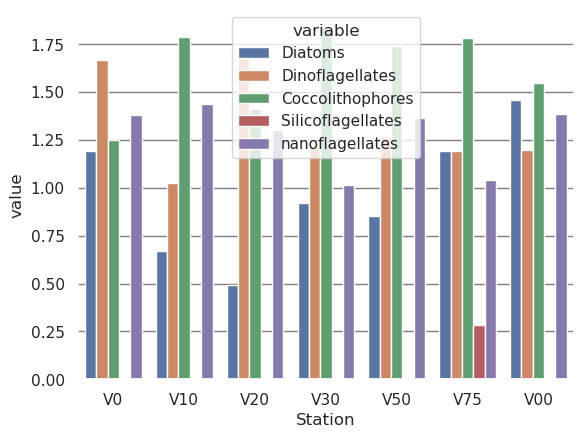

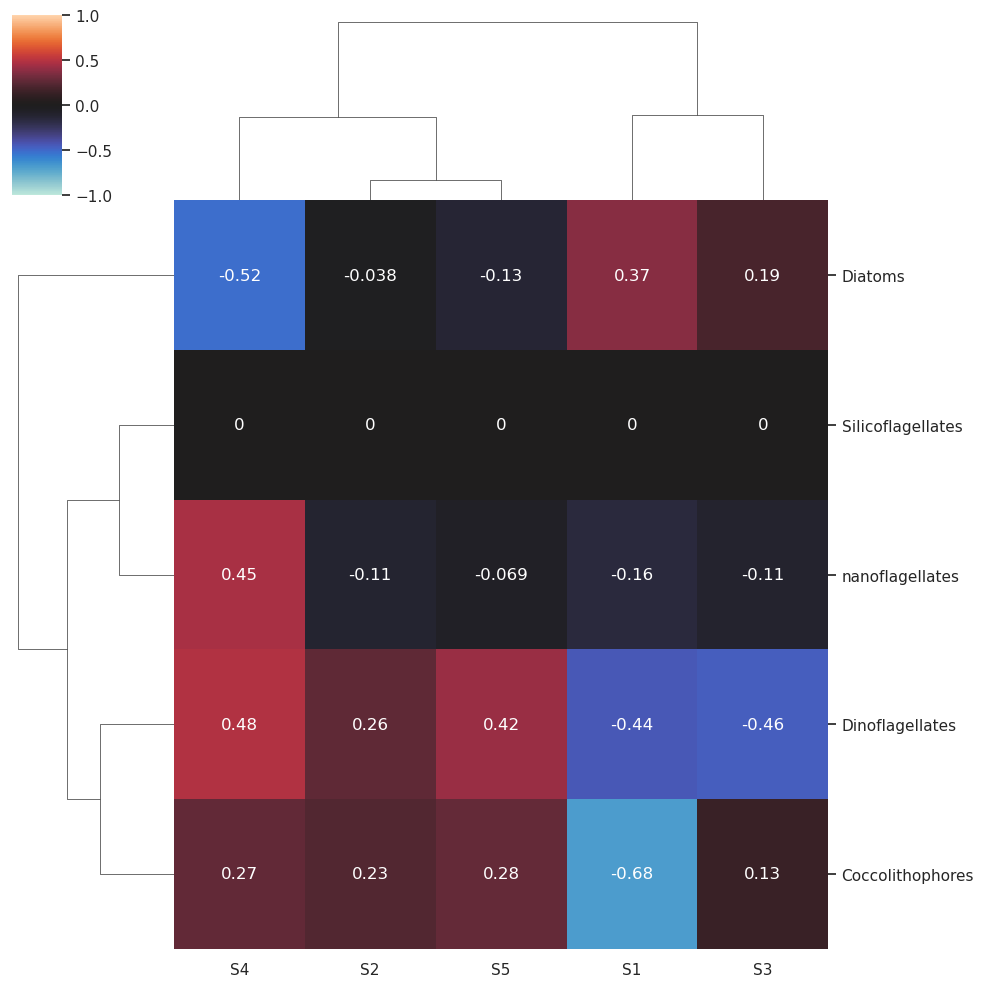

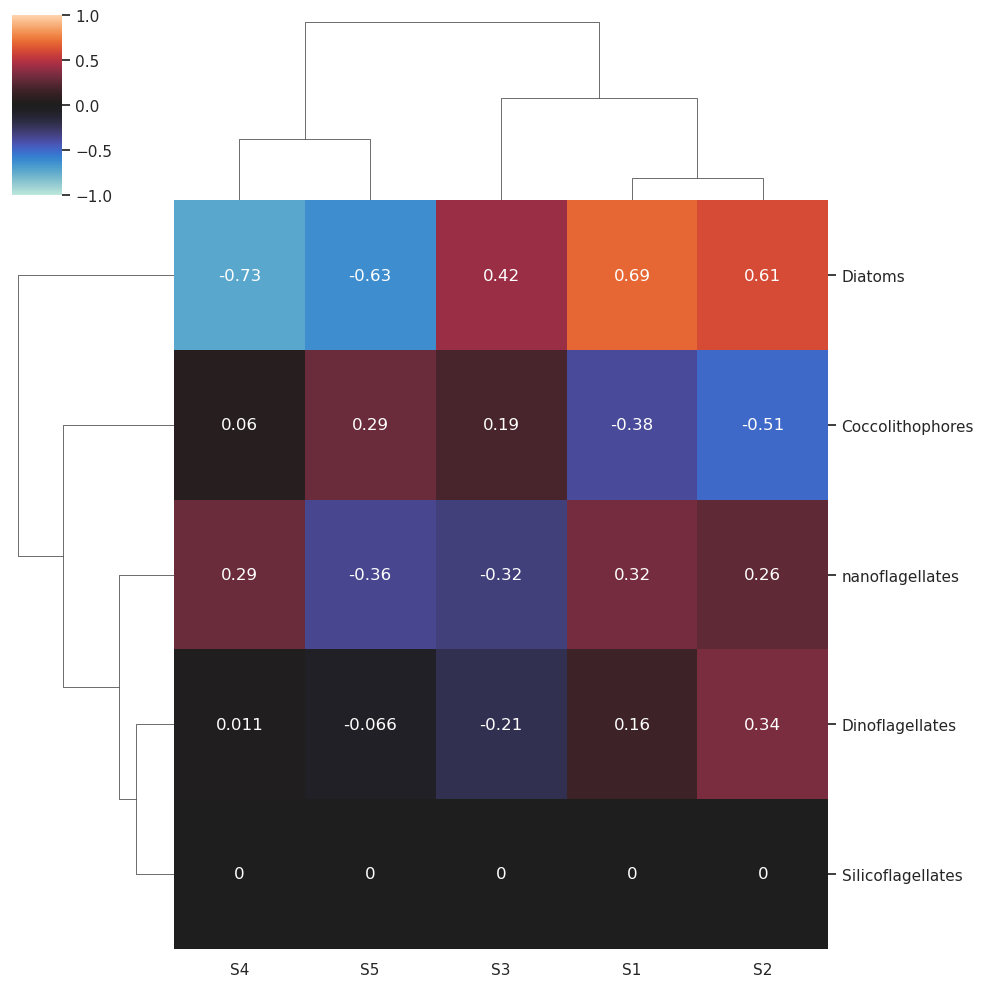

In [167]:
sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'gray'})
fit_sum = pd.read_csv("KastelVisExp/Fitoplankton  st101 i cj009 _13.6.23_.xlsx - MateoSumFito.csv")
fit_sum = fit_sum.melt(id_vars=['depth', 'Station', 'Location'])
fit_sum['value'] = np.log10(fit_sum['value'] +1)

sb.barplot(fit_sum.query("Location == 'Kastela'") , x = 'Station', y = 'value', hue='variable')
plt.savefig('plots/bar_plot_sum_fito_kastela.pdf', dpi=20)
plt.close()
sb.barplot(fit_sum.query("Location == 'Vis'"), x = 'Station', y = 'value', hue='variable')
plt.savefig('plots/bar_plot_sum_fito_vis_all_meters.pdf', dpi=20)



fit_sum = pd.read_csv("KastelVisExp/Fitoplankton  st101 i cj009 _13.6.23_.xlsx - MateoSumFito.csv")
fit_sum = fit_sum.merge(signatures_in_both, left_on='Station', right_on='sample')
for_cor = fit_sum[fit_sum['Location'] == 'Kastela'].corr().fillna(0)
for_cor = for_cor.drop(index=['depth_x', 'depth_y', 'S1', 'S2', 'S3', 'S4', 'S5'])

sb.clustermap(for_cor[['S1', 'S2', 'S3', 'S4', 'S5']], annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True), method='ward')
plt.savefig("plots/cito_sigs_cor_kastela.pdf", dpi=20)


for_cor = fit_sum[fit_sum['Location'] == 'Vis'].corr().fillna(0)
for_cor = for_cor.drop(index=['depth_x', 'depth_y', 'S1', 'S2', 'S3', 'S4', 'S5'])

sb.clustermap(for_cor[['S1', 'S2', 'S3', 'S4', 'S5']], annot=True,vmin=-1, vmax=1, cmap=sb.color_palette("icefire", as_cmap=True), method='ward')
plt.savefig("plots/cito_sigs_cor_vis.pdf", dpi=20)

/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/mateo/anaconda3/envs/NMF_Gea275_Project/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


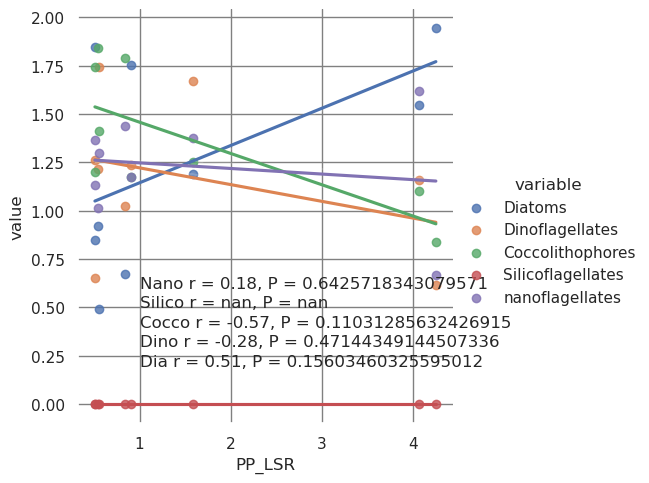

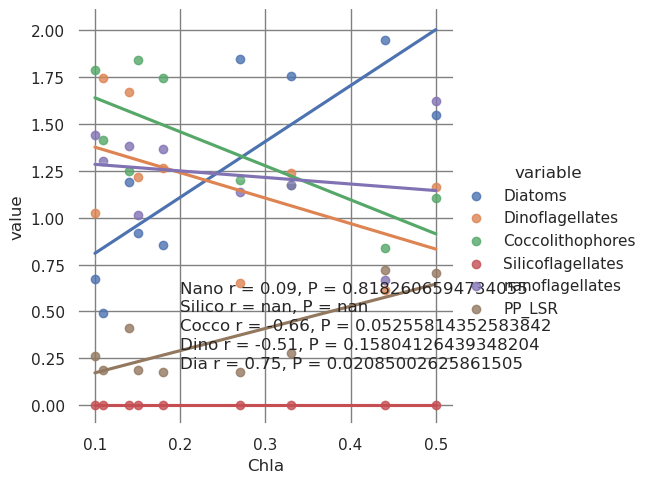

In [165]:
ppp_data = pd.read_csv("KastelVisExp/c14_grfs_mateo - Sheet1.csv")
fit_sum = pd.read_csv("KastelVisExp/Fitoplankton  st101 i cj009 _13.6.23_.xlsx - MateoSumFito.csv")
fit_sum = fit_sum.merge(ppp_data, left_on='Station', right_on='Station')

fit_sum = fit_sum[['Diatoms', 'Dinoflagellates', 'Coccolithophores', 'Silicoflagellates', 'nanoflagellates', 'Station', 'WhoDidIt', 'PP_LSR', 'Chla']]
fit_sum = fit_sum[fit_sum['WhoDidIt'] == 'Marinix']
for_plot = fit_sum.melt(id_vars=['Station', 'WhoDidIt' , 'PP_LSR'])
for_plot['value'] = np.log10(for_plot['value'] + 1)
for_plot = for_plot[for_plot['variable'] != 'Chla']

r1 = scipy.stats.pearsonr(x=fit_sum['Diatoms'], y=fit_sum['PP_LSR'])
r2 = scipy.stats.pearsonr(x=fit_sum['Dinoflagellates'], y=fit_sum['PP_LSR'])
r3 = scipy.stats.pearsonr(x=fit_sum['Coccolithophores'], y=fit_sum['PP_LSR'])
r4 = scipy.stats.pearsonr(x=fit_sum['Silicoflagellates'], y=fit_sum['PP_LSR'])
r5 = scipy.stats.pearsonr(x=fit_sum['nanoflagellates'], y=fit_sum['PP_LSR'])

sb.lmplot(for_plot, x='PP_LSR', y='value', hue='variable',ci=False)
plt.text(1, 0.2, 'Dia r = {}, P = {}'.format(round(r1.statistic,2),r1.pvalue))
plt.text(1, 0.3, 'Dino r = {}, P = {}'.format(round(r2.statistic,2),r2.pvalue))
plt.text(1, 0.4, 'Cocco r = {}, P = {}'.format(round(r3.statistic,2),r3.pvalue))
plt.text(1, 0.5, 'Silico r = {}, P = {}'.format(round(r4.statistic,2),r4.pvalue))
plt.text(1, 0.6, 'Nano r = {}, P = {}'.format(round(r5.statistic,2),r5.pvalue))
plt.savefig("plots/PPP_fito_corr.pdf", dpi = 20)

for_plot = fit_sum.melt(id_vars=['Station', 'WhoDidIt' , 'Chla'])
for_plot['value'] = np.log10(for_plot['value'] + 1)

r1 = scipy.stats.pearsonr(x=fit_sum['Diatoms'], y=fit_sum['Chla'])
r2 = scipy.stats.pearsonr(x=fit_sum['Dinoflagellates'], y=fit_sum['Chla'])
r3 = scipy.stats.pearsonr(x=fit_sum['Coccolithophores'], y=fit_sum['Chla'])
r4 = scipy.stats.pearsonr(x=fit_sum['Silicoflagellates'], y=fit_sum['Chla'])
r5 = scipy.stats.pearsonr(x=fit_sum['nanoflagellates'], y=fit_sum['Chla'])

sb.lmplot(for_plot, x='Chla', y='value', hue='variable',ci=False)
plt.text(0.2, 0.2, 'Dia r = {}, P = {}'.format(round(r1.statistic,2),r1.pvalue))
plt.text(0.2, 0.3, 'Dino r = {}, P = {}'.format(round(r2.statistic,2),r2.pvalue))
plt.text(0.2, 0.4, 'Cocco r = {}, P = {}'.format(round(r3.statistic,2),r3.pvalue))
plt.text(0.2, 0.5, 'Silico r = {}, P = {}'.format(round(r4.statistic,2),r4.pvalue))
plt.text(0.2, 0.6, 'Nano r = {}, P = {}'.format(round(r5.statistic,2),r5.pvalue))
plt.savefig("plots/chla_fito_corr.pdf", dpi = 20)
#

In [161]:
for_plot

,Station,WhoDidIt,PP_LSR,variable,value
0,K0,Marinix,4.25,Diatoms,1.945382
2,K5,Marinix,4.06,Diatoms,1.548461
4,K10,Marinix,0.91,Diatoms,1.754455
6,K20,Marinix,0.51,Diatoms,1.844725
8,V0,Marinix,1.59,Diatoms,1.190439
10,V10,Marinix,0.84,Diatoms,0.672001
12,V20,Marinix,0.55,Diatoms,0.492098
14,V30,Marinix,0.54,Diatoms,0.919124
16,V50,Marinix,0.51,Diatoms,0.851247
18,K0,Marinix,4.25,Dinoflagellates,0.614855
